**Resources**
- [H.264 Book](https://last.hit.bme.hu/download/vidtech/k%C3%B6nyvek/Iain%20E.%20Richardson%20-%20H264%20\(2nd%20edition\).pdf)
- [Digital Video Introduction](https://github.com/leandromoreira/digital_video_introduction)
- [JPEG: A Signal Processing Approach](https://www.youtube.com/watch?v=0me3guauqOU&t=1735s)
- [JPEG spec](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)
- [Purdue JPEG Lab](https://engineering.purdue.edu/~bouman/grad-labs/JPEG-Image-Coding/pdf/lab.pdf)

## Frames

In [1]:
import ffmpeg
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bitstring import BitStream, Bits
from typing import Optional
from rich.traceback import install
import cv2

%matplotlib inline

In [2]:
# install(show_locals=True, suppress=[np,pd,cv2,ffmpeg,plt])

In [3]:
def get_video_stats(filename):
    probe = ffmpeg.probe(filename)
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream:
        return int(video_stream['width']), int(video_stream['height']), int(video_stream['avg_frame_rate'].split('/')[0])
    else:
        return None, None, None

def frame(i):
    width, height, fps = get_video_stats('data/test.mov')
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i/fps)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

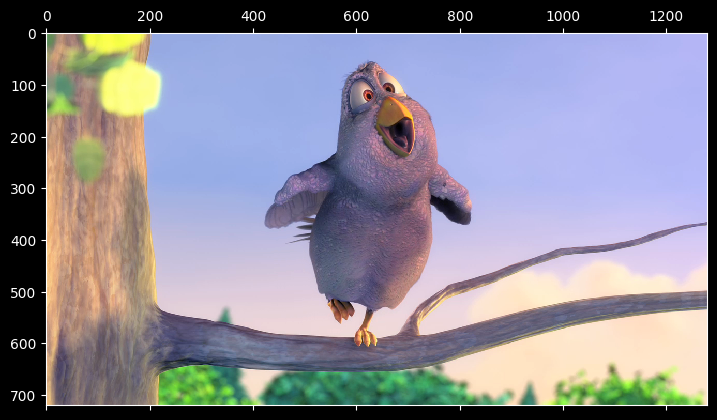

In [4]:
plt.matshow(frame(400));

## Chroma Subsampling

In [5]:
def subsample(yuv: np.ndarray) -> np.ndarray:
    y = yuv[:,:,0]
    u = yuv[::2,::2,1]
    v = yuv[::2,::2,2]
    return y,u,v

def rgb2yuv(rgb):
    yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)
    return subsample(yuv.astype(np.uint8))

In [6]:
def yuv2rgb(y,u,v):
    u = u.repeat(2, axis=0).repeat(2, axis=1)
    v = v.repeat(2, axis=0).repeat(2, axis=1)
    yuv = np.dstack((y,u,v))
    print(yuv.shape)
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    return rgb.astype(np.uint8)

In [7]:
def plot_yuv(*yuv):
    y,u,v = yuv
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(u, label='U', cmap='Blues')
    ax[1].title.set_text('U')
    ax[2].matshow(v, label='V', cmap='Reds')
    ax[2].title.set_text('V')
    plt.show()

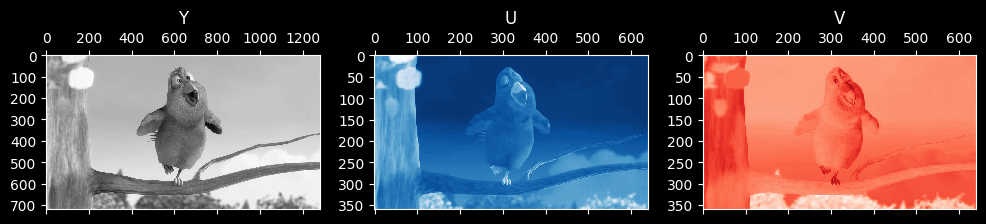

In [8]:
plot_yuv(*rgb2yuv(frame(400)))

## Transform + Quantization

In [9]:
def M(QP: int) -> np.ndarray:
    m0 = [13107,11916,10082,9362,8192,7282][QP%6]
    m1 = [5243,4660,4194,3647,3355,2893][QP%6]
    m2 = [8066,7490,6554,5825,5243,4559][QP%6]
    return np.array([[m0,m2,m0,m2],[m2,m1,m2,m1],[m0,m2,m0,m2],[m2,m1,m2,m1]])

def transform(X: np.ndarray, QP=6) -> np.ndarray:
    C = np.array([[1,1,1,1],[2,1,-1,-2],[1,-1,-1,1],[1,-2,2,-1]])
    return np.fix(((C@X@C.T*M(QP)))/(2.**(15+(QP//6)))).astype(np.int64)


In [10]:
def V(QP: int) -> np.ndarray:
    v0 = [10,11,13,14,16,18][QP%6]
    v1 = [16,18,20,23,25,29][QP%6]
    v2 = [13,14,16,18,20,23][QP%6]
    return np.array([[v0,v2,v0,v2],[v2,v1,v2,v1],[v0,v2,v0,v2],[v2,v1,v2,v1]])

def inverse_transform(Y: np.ndarray, QP=6) -> np.ndarray:
    C = np.array([[1,1,1,1],[1,.5,-.5,-1],[1,-1,-1,1],[.5,-1,1,-.5]])
    return (((C.T@((Y*V(QP))<<(QP//6))@C).astype(np.int64)))>>6

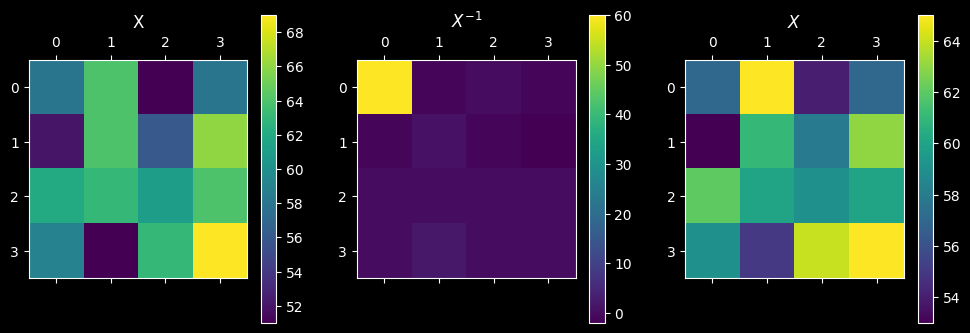

(array([[58, 64, 51, 58],
        [52, 64, 56, 66],
        [62, 63, 61, 64],
        [59, 51, 63, 69]]),
 array([[60, -1,  0, -1],
        [-1,  1, -1, -2],
        [ 0,  0,  0,  0],
        [ 0,  2,  0,  0]]),
 array([[57, 65, 54, 57],
        [53, 61, 58, 63],
        [62, 60, 59, 60],
        [59, 55, 64, 65]]))

In [11]:
QP = 16
X = np.array([[58,64,51,58],[52,64,56,66],[62,63,61,64],[59,51,63,69]])
# X = (np.random.random((4,4))*256).astype(np.int64)
Y = transform(X, QP)
Z = inverse_transform(Y, QP)

# graph X and Y on two subplots with colorbars
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].title.set_text('X')
ax[1].title.set_text('$X^{{-1}}$')
ax[2].title.set_text('$X$')
fig.colorbar(ax[0].matshow(X), ax=ax[0])
fig.colorbar(ax[1].matshow(Y), ax=ax[1])
fig.colorbar(ax[2].matshow(Z), ax=ax[2])
plt.show()

X, Y, Z

## Quantize Frame

In [12]:
def quantize_frame(image, QP=6):
    height, width = image.shape
    h_blocks, w_blocks = height // 4, width // 4
    blocks = image.reshape(h_blocks, 4, w_blocks, 4)
    blocks = blocks.transpose(0, 2, 1, 3).reshape(-1, 4, 4)
    output = inverse_transform(transform(blocks, QP), QP)
    result = output.reshape(h_blocks, w_blocks, 4, 4)
    result = result.transpose(0, 2, 1, 3).reshape(height, width)
    return result

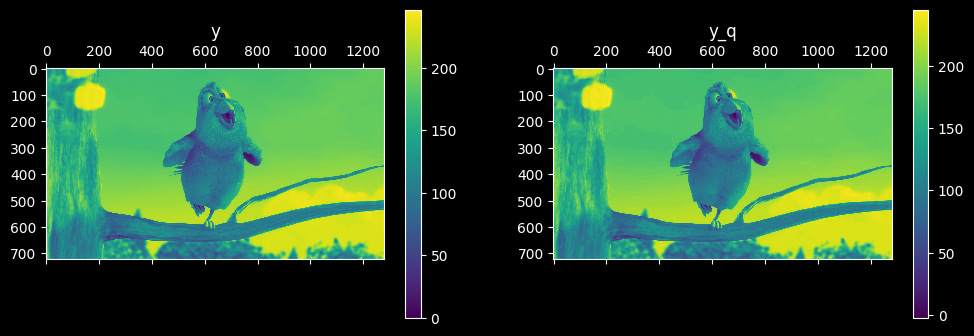

In [13]:
y, _, _ = rgb2yuv(frame(404))
y_q = quantize_frame(y,QP=24)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].title.set_text('y')
ax[1].title.set_text('y_q')
fig.colorbar(ax[0].matshow(y), ax=ax[0])
fig.colorbar(ax[1].matshow(y_q), ax=ax[1])
plt.show()

## Entropy Coding

In [14]:
# Create index arrays for rows and columns
z_rows = np.array([0,0,1,2,1,0,0,1,2,3,3,2,1,2,3,3])
z_cols = np.array([0,1,0,0,1,2,3,2,1,0,1,2,3,3,2,3])

def zigzag(X: np.ndarray) -> np.ndarray:
    return X[z_rows, z_cols]

def unzigzag(Y: np.ndarray) -> np.ndarray:
    X = np.zeros((4,4), dtype=np.int16)
    for i in range(16):
        X[z_rows[i], z_cols[i]] = Y[i]
    return X

In [15]:
def load_lookup(path):
    lookup = pd.read_csv(path, dtype=str, skipinitialspace=True)['Code'].to_numpy(dtype=str)
    rev_lookup = {str(v) : i for i, v in enumerate(lookup)}
    return lookup, rev_lookup

In [16]:
luma_dc, rev_luma_dc        = load_lookup('data/k3.csv')
chroma_dc, rev_chroma_dc    = load_lookup('data/k4.csv')
luma_ac, rev_luma_ac        = load_lookup('data/k5.csv')
chroma_ac, rev_chroma_ac    = load_lookup('data/k6.csv')

In [17]:
def entropy_code_dc(dc: np.ndarray, luma: bool, s: BitStream):
    lookup = luma_dc if luma else chroma_dc
    width = int(np.ceil(np.log2(np.abs(dc)+1)))
    x = ((dc-1 if dc < 0 else dc)&((1<<width)-1))
    size = lookup[width]
    s.append(Bits(bin=size))
    if width > 0:
        s.append(Bits(uint=x, length=width))
    return s

def entropy_code_ac(ac: np.ndarray, luma: bool, s: BitStream):
    lookup = luma_ac if luma else chroma_ac
    i = 0
    zc = 0
    EOB = lookup[0]

    while i < len(ac):
        if ac[i] == 0:
            zc += 1
        else:
            x = ac[i]
            width = int(np.ceil(np.log2(np.abs(x)+1)))
            x = ((x-1 if x < 0 else x)&((1<<width)-1))
            run_size = lookup[1+zc*10+(width-1)]
            s.append(Bits(bin=run_size))
            if width > 0:
                s.append(Bits(uint=x, length=width))
            zc = 0
        i += 1

    s.append(Bits(bin=EOB))

    return s

def entropy_code_block(block: np.ndarray, luma: bool, s: BitStream):
    z = zigzag(block)
    s = entropy_code_dc(z[0], luma, s)
    s = entropy_code_ac(z[1:], luma, s)
    return s

In [18]:
ys = entropy_code_block(Y, True, BitStream())
ys.bits

BitStream('0xef00ce07cdb6, 0b10')

In [19]:
def encode_plane(plane: np.ndarray, QP: int, luma: bool, s: BitStream) -> BitStream:
    height, width = plane.shape
    h_blocks, w_blocks = height // 4, width // 4
    # numpy broadcasting for vectorization
    blocks = plane.reshape(h_blocks, 4, w_blocks, 4)
    blocks = blocks.transpose(0, 2, 1, 3).reshape(-1, 4, 4)
    # integer transform
    xform = transform(blocks, QP)
    # delta encoding
    xform[1:,0,0] = xform[1:,0,0] - xform[:-1,0,0]
    # entropy coding
    for block in xform:
        s =entropy_code_block(block, luma, s)
    return s

def encode_frame(frame: np.ndarray, QP: int) -> BitStream:
    s = BitStream()
    y, u, v = rgb2yuv(frame)
    s = encode_plane(y, QP, True, s)
    s = encode_plane(u, QP, False, s)
    s = encode_plane(v, QP, False, s)
    rem = 8-(len(s)%8)
    if rem < 8:
        s.append(Bits(uint=0,length=rem))
    return s

In [20]:
F = frame(404)
F.shape

(720, 1280, 3)

In [21]:
E = encode_frame(F, 24)

In [22]:
print(f"number of bits: {len(E)}")
print(f"compression rate: {len(E) / (1280*720*3*8) :.2%}")

number of bits: 739208
compression rate: 3.34%


## Entropy Decoding

In [23]:
def entropy_decode_dc(s: BitStream, luma: bool) -> np.int16:
    lookup = rev_luma_dc if luma else rev_chroma_dc
    size = 0
    i = 0

    while True:
        size_buf = s.peek(i)
        if size_buf.bin in lookup:
            size = lookup[size_buf.bin]
            s.read(i)
            break
        i += 1

    if size > 0:
        dc = s.read(size).uint
        dc = dc if dc >= (1 << (size-1)) else (dc - (1 << (size)) + 1)
        return dc

    return 0

def entropy_decode_ac(s: BitStream, luma: bool) -> np.ndarray:
    lookup = rev_luma_ac if luma else rev_chroma_ac
    out = np.zeros(15, dtype=np.int16)
    c = 0
    run_size = 0

    while True:
        i = 0
        while True:
            run_size_buf = s.peek(i)
            if run_size_buf.bin in lookup:
                run_size = lookup[run_size_buf.bin]
                s.read(i)
                break
            i += 1

        if run_size == 0:
            break

        run = (run_size - 1) // 10
        size = (run_size - 1) % 10 + 1

        while run > 0:
            out[c] = 0
            run -= 1
            c += 1

        if size > 0:
            ac = s.read(size).uint
            ac = ac if ac >= (1 << (size-1)) else (ac - (1 << (size)) + 1)
            out[c] = ac

        c += 1

    return out

def entropy_decode_block(s: BitStream, luma: bool) -> np.ndarray:
    z = np.zeros(16, dtype=np.int16)
    z[0] = entropy_decode_dc(s, luma)
    z[1:] = entropy_decode_ac(s, luma)
    return unzigzag(z)

In [24]:
entropy_decode_block(ys.bits, True)

array([[60, -1,  0, -1],
       [-1,  1, -1, -2],
       [ 0,  0,  0,  0],
       [ 0,  2,  0,  0]], dtype=int16)

In [25]:
def decode_plane(s: BitStream, QP: int, luma: bool) -> np.ndarray:
    if luma:
        height, width = 720, 1280
    else:
        height, width = 360, 640
    h_blocks, w_blocks = height // 4, width // 4
    blocks = np.zeros((h_blocks*w_blocks, 4, 4), dtype=np.int16)
    for i in range(h_blocks*w_blocks):
        blocks[i] = entropy_decode_block(s, luma)
    blocks[1:,0,0] = blocks[1:,0,0] + np.cumsum(blocks[:-1,0,0])
    output = inverse_transform(blocks, QP)
    result = output.reshape(h_blocks, w_blocks, 4, 4)
    result = result.transpose(0, 2, 1, 3).reshape(height, width).astype(np.uint8)
    return result

def decode_frame(s: BitStream, QP: int) -> np.ndarray:
    y = decode_plane(s, QP, True)
    u = decode_plane(s, QP, False)
    v = decode_plane(s, QP, False)
    return yuv2rgb(y,u,v)

In [26]:
D = decode_frame(E.bits, 24)

(720, 1280, 3)


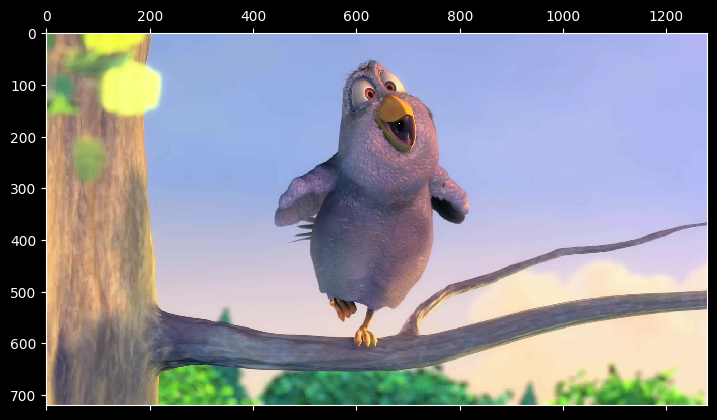

In [27]:
plt.matshow(D)